In [31]:
import os
import pandas as pd
import numpy as np
from numpy import var, mean, sqrt
import pyfaidx
import pysam
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests

In [32]:
MUT_DATA = "../data/annotated_snv_mv_indels_by_cancer_subtype"
DRIVER_GENES = "../data/driver_genes"
TFBS_DATA = "../data/TFBS_data_diff"
REF_FASTA = "../data/ref/hg19.fa"
DRIVER_GENES_PANCAN = "../data/datasets/driver_genes_intogen/Pancancer.tsv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

RESULTS_DIR = "../results/TFBS_diff_by_cancer"
PLOT_DATA_DIR = "../plot_data/TFBS_Fabian"
os.makedirs(PLOT_DATA_DIR, exist_ok=True)

if not os.path.exists(RESULTS_DIR):
	os.makedirs(RESULTS_DIR)

# Fasta sequence extractor
pyfaidx.Faidx(REF_FASTA)
REF_GENOME_OPEN = pysam.Fastafile(REF_FASTA) 

In [33]:
cancer_type = "Lymph-BNHL"  # specify cancer type here

In [34]:
driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, f"{cancer_type}.tsv"), sep="\t")
driver_genes_list = driver_genes["gene"].tolist()

In [35]:
mut_df = pd.read_csv(f"{MUT_DATA}/{cancer_type}.tsv", sep="\t")
mut_df = mut_df[["Tumor_Sample_Barcode", "mutation", "gene", "driver", "has_driver", "genic_region"]]
mut_df = mut_df[mut_df["gene"].isin(driver_genes_list)]

# get driver status
mut_df["driver_status"] = mut_df.apply(lambda x: "Passengers in presence of driver" if x["has_driver"] else "Passengers in absence of driver", axis=1)
mut_df["driver_status"] = mut_df.apply(lambda x: "Drivers" if x["driver"] else x["driver_status"], axis=1)

In [36]:
def get_key(mutation):
	'''
	Generate a key to match the mutation format for TFBS data
	Used to merge the two dataframes on the mutation
	'''
	chrom, pos, ref, alt = mutation.split(":")
	pos = pos.split("-")[0]
	# using 0-based indexing for pysam fetch
	start = int(pos)-1
	end = int(pos)
	# include the previous base in case of indels and MNVs
	if ref == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		pos = int(pos) - 1
	elif alt == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		pos = int(pos) - 1
	elif len(ref) > 1 or len(alt) > 1:
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start) + alt
		pos = int(pos) - 1
	key = f"chr{chrom}:{pos}{ref}>{alt}"
	return key

# add variant column to use as key for TFBS data
mut_df["variant"] = mut_df["mutation"].apply(get_key)

In [37]:
# TFBS data
tf_cancer_file = f"{TFBS_DATA}/{cancer_type}.tsv"
if not os.path.exists(tf_cancer_file):
	print(f"TFBS data file not found for {cancer_type}")
tfbs_df = pd.read_csv(f"{TFBS_DATA}/{cancer_type}.tsv", sep="\t")
tfbs_df = tfbs_df[["variant", "tf", "score"]]
# remove duplicates
tfbs_df = tfbs_df.drop_duplicates(subset=["variant", "tf"])
tfbs_df["variant_tf"] = tfbs_df["variant"] + "_" + tfbs_df["tf"]
tfbs_var_dict = tfbs_df.set_index("variant_tf")["score"].to_dict()

In [38]:
mut_tf_df = mut_df[["Tumor_Sample_Barcode", "variant", "gene", "driver_status", "genic_region"]].copy()
mut_tf_df = mut_tf_df[mut_tf_df["genic_region"] == "upstream"]
print(mut_tf_df.shape)
mut_tf_df.drop_duplicates(inplace=True)
print(mut_tf_df.shape)

(183, 5)
(183, 5)


In [39]:
def cohen_d(x, y):
    # size of samples
    n1, n2 = len(x), len(y)
    # variance of the samples
    s1, s2 = var(x, ddof=1), var(y, ddof=1)
    # pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # means of the samples
    u1, u2 = mean(x), mean(y)
    # return the effect size
    return (u1 - u2) / s

In [40]:
tf_diff = []
tfs = tfbs_df["tf"].unique().tolist()
mut_tf_data = pd.DataFrame()
for tf in tfs:
	mut_data_df = mut_tf_df.copy()
	mut_data_df["tf"] = tf
	mut_data_df["score"] = mut_data_df.apply(lambda x: tfbs_var_dict.get(f"{x['variant']}_{tf}", 0), axis=1).astype(float)
	mut_data_df["abs_score"] = mut_data_df["score"].abs()
	mut_data_df["prediction"] = mut_data_df["score"].apply(lambda x: "gain" if x > 0 else "loss")
	mut_data_df["prediction"] = mut_data_df["prediction"].apply(lambda x: "no change" if x == 0 else x)
	mut_tf_data = pd.concat([mut_tf_data, mut_data_df], axis=0)
mut_tf_data.reset_index(drop=True, inplace=True)
print(mut_tf_data.shape)

(253821, 9)


In [41]:
def get_cancer_gene_type(is_oncogene, is_tsg):
    if is_oncogene == "Yes" and is_tsg == "No":
        return "OG"
    elif is_oncogene == "No" and is_tsg == "Yes":
        return "TSG"
    elif is_oncogene == "Yes" and is_tsg == "Yes":
        return "Both"
    else:
        return "Neither"

cancer_gene_type = pd.read_csv(CANCER_GENE_TYPES, sep="\t")
cancer_gene_type["type"] = cancer_gene_type.apply(lambda x: get_cancer_gene_type(x["Is Oncogene"], x["Is Tumor Suppressor Gene"]), axis=1)
cancer_gene_type = cancer_gene_type[["Hugo Symbol", "type"]]
cancer_gene_type.columns = ["gene", "type"]
mut_tf_data = mut_tf_data.merge(cancer_gene_type, on="gene", how="left")
mut_tf_data["type"] = mut_tf_data["type"].fillna("Neither")

In [42]:
# gene = "FBXW7"
# plot_data = mut_tf_data[mut_tf_data["gene"] == gene]
plot_data = mut_tf_data[mut_tf_data["driver_status"] != "Drivers"]
print(plot_data.shape)

(253821, 10)


In [43]:
# Group by TF and condition to get list of scores
grouped = plot_data.groupby(['tf', 'driver_status'])['abs_score'].apply(list).unstack()

# Compute statistics
results = []
for tf in grouped.index:
    group1 = grouped.loc[tf, 'Passengers in absence of driver']
    group2 = grouped.loc[tf, 'Passengers in presence of driver']
    stat, pval = ttest_ind(group1, group2, equal_var=False)
    diff = np.mean(group1) - np.mean(group2)
    results.append({'tf': tf, 'p_val': pval, 'diff': diff})
    
volcano_df = pd.DataFrame(results)
volcano_df.dropna(inplace=True) 
volcano_df["log_p"] = volcano_df["p_val"].apply(lambda x: -np.log10(x))
# multiple testing correction
rejected, pvals_corrected, _, _ = multipletests(volcano_df['p_val'], method='fdr_bh')
volcano_df['pval_adj'] = pvals_corrected
volcano_df["log_p_adj"] = volcano_df["pval_adj"].apply(lambda x: -np.log10(x))
volcano_df["direction"] = volcano_df["diff"].apply(lambda x: "Larger effects in\nabsence of driver" if x > 0 else "Larger effects in\npresence of driver")

# count number of TFs with significant p-values
num_significant = len(volcano_df[volcano_df["pval_adj"] < 0.05])
print(f"Number of TFs with significant p-values: {num_significant}")
num_non_significant = len(volcano_df[volcano_df["pval_adj"] >= 0.05])
print(f"Number of TFs without significant p-values: {num_non_significant}")

Number of TFs with significant p-values: 295
Number of TFs without significant p-values: 1092


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99954/2947974216.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


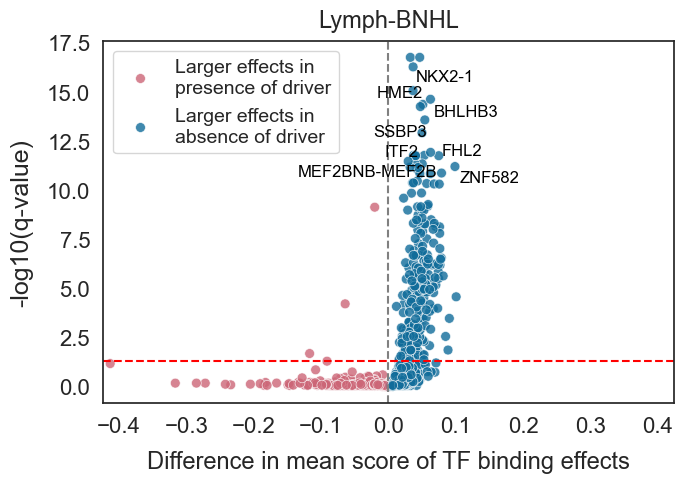

In [44]:
plt.figure(figsize=(7, 5))
sns.set(style="white")
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

sns.scatterplot(
    data=volcano_df, 
    x='diff', 
    y='log_p_adj',
	hue='direction',
	palette=cmap,
	s=50,
	edgecolor='w',
	linewidth=0.5,
	alpha=0.8
)
plt.axhline(-np.log10(0.05), color='red', linestyle='--')  # p = 0.05 cutoff
plt.axvline(0, color='gray', linestyle='--')  # no difference cutoff

# center x axis at 0
max_abs = max(abs(volcano_df["diff"].min()), abs(volcano_df["diff"].max()))
max_abs += 0.01
plt.xlim(-max_abs, max_abs)

# avoid overlapping text
annot = []
top_tfs = volcano_df.nlargest(20, 'log_p_adj')["tf"].tolist() # get top TFs by significance
diff_threshold = 0.05
for index, row in volcano_df.iterrows():
	if row["log_p_adj"] > -np.log10(0.05) and row["diff"] > diff_threshold and row["tf"] in top_tfs:
		annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='black'))
	elif row["log_p_adj"] > -np.log10(0.05) and row["diff"] < -diff_threshold and row["tf"] in top_tfs:
		annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='red'))
adjust_text(annot)

plt.xticks(fontsize=16)
plt.xlabel('Difference in mean score of TF binding effects', fontsize=17, labelpad=10)
plt.yticks(fontsize=16)
plt.ylabel('-log10(q-value)', fontsize=18, labelpad=10)
plt.title(f"{cancer_type}", fontsize=17, pad=10)
# create custom legend
legend_elements = [
	plt.Line2D([0], [0], marker='o', color=colors[0], label='Bigger effects in\nabsence of drivers', markerfacecolor='red', markersize=7),
	plt.Line2D([0], [0], marker='o', color=colors[1], label='Bigger effects in\npresence of drivers', markerfacecolor='black', markersize=7)
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=14)
plt.legend(title_fontsize=14, loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/{cancer_type}_tfbs_diff.png", bbox_inches='tight', dpi=300)

# source data
volcano_df[["tf", "diff", "p_val", "pval_adj"]].to_csv(f"{PLOT_DATA_DIR}/{cancer_type}_tfbs_diff.tsv", sep="\t", index=False)